# Step #1 Loading the Data

In [94]:
# A tutorial for this file will be shortly available at www.relataly.com
# Tested with python 3.9.13, matplotlib 3.6.2, numpy 1.23.3, seaborn=0.12.1, fairlearn=0.8.0, plotly 5.11.0

# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics as skm
from fairlearn.metrics import MetricFrame, selection_rate, selection_rate_difference, count, plot_model_comparison
from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# read the adult data
# predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.
# https://archive.ics.uci.edu/ml/datasets/adult

from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, parser='auto', as_frame=True)

X_df = data.data.copy()
data.target = data.target.replace({' <=50K': 0, ' >50K': 1})
y_df = data.target

# Declare sensitive features
sensitive_variables = ["sex", 'race']

# join X_df and y_df and name y_df as 'income'
X_df['salary >50k'] = y_df

# show df that contains the target column
X_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary >50k
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


# Step #2 Preprocessing and Visualization

(array([0, 1]), [Text(0, 0, ' Black'), Text(1, 0, ' White')])

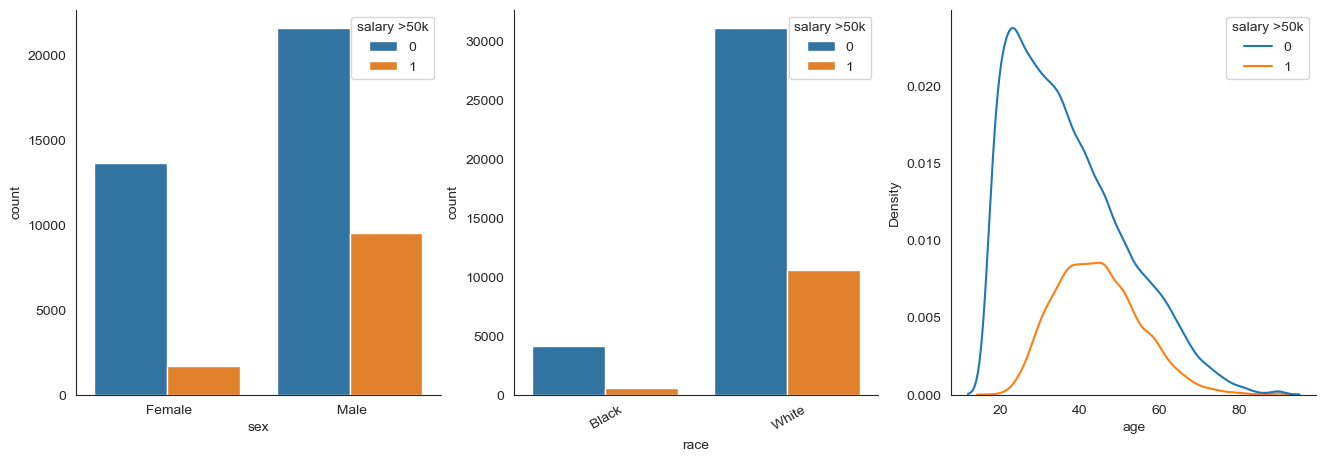

In [95]:
# encode the categorical features
X_df['workclass'] = X_df['workclass'].cat.codes
X_df['education'] = X_df['education'].cat.codes
X_df['marital-status'] = X_df['marital-status'].cat.codes
X_df['occupation'] = X_df['occupation'].cat.codes
X_df['relationship'] = X_df['relationship'].cat.codes

# filter some values to reduce tutorial complexity and make it easier to visualize
X_df = X_df.loc[X_df["race"].astype(str).isin([" White", " Black"])]
X_df.race = X_df.race.cat.remove_unused_categories()

# ensure that the target column has the same filter applied
y_df = X_df['salary >50k']

# create a copy of the df for visualization
df_visu = X_df.copy()

# drop the target column from X_df
X_df.drop(['salary >50k'], axis=1, inplace=True)

# visualize the distributions of the cateogical variables
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
sns.countplot(x='sex', hue='salary >50k', data=df_visu, ax=ax[0])
sns.countplot(x='race', hue='salary >50k', data=df_visu, ax=ax[1])
sns.kdeplot(x='age', hue='salary >50k', data=df_visu, ax=ax[2])

# rotate x_labels
plt.sca(ax[1])
plt.xticks(rotation=30)

# Step #3 Splitting and Scaling the Data

In [96]:
# create a dataframe with sensitive features
A = X_df[sensitive_variables]
X = X_df.drop(labels=sensitive_variables, axis=1)
X = pd.get_dummies(X)

# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Encode the target variable
le = LabelEncoder()
Y_encoded = le.fit_transform(y_df)

# We split the data into training and test sets:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X_scaled, Y_encoded, A, test_size=0.4, random_state=0, stratify=Y_encoded
)

# Work around indexing bug
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

# Step #4 Train an Fairness-Unaware Model and Assess its Fairness

accuracy              0.822003
selection_rate        0.150385
count             18579.000000
dtype: float64
                accuracy  selection_rate    count
sex     race                                     
 Female  Black  0.944559        0.026694    974.0
         White  0.875715        0.065193   5246.0
 Male    Black  0.866808        0.125793    946.0
         White  0.783142        0.202138  11413.0


array([[<AxesSubplot: title={'center': 'accuracy'}, xlabel='sex,race'>,
        <AxesSubplot: title={'center': 'selection_rate'}, xlabel='sex,race'>,
        <AxesSubplot: title={'center': 'count'}, xlabel='sex,race'>]],
      dtype=object)

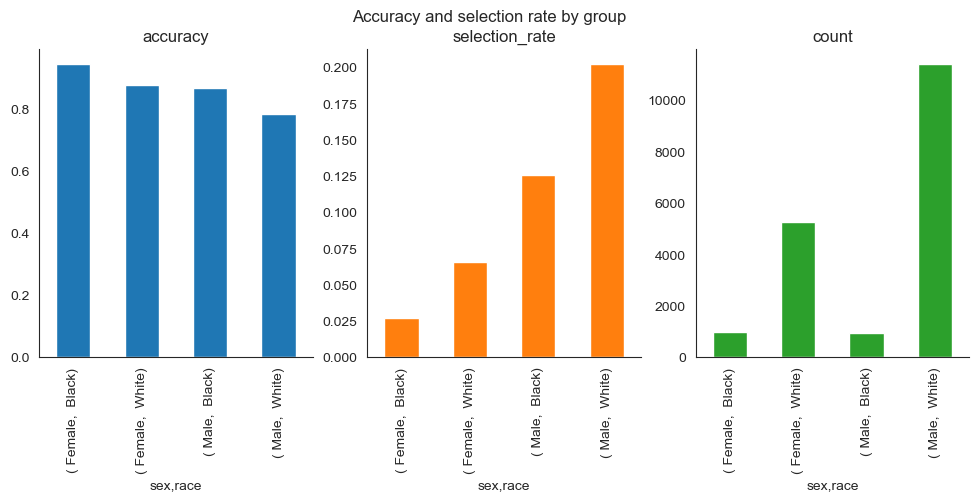

In [97]:
# Define evaluation metrics for performance and fairness
performance_metric = skm.accuracy_score
fairness_metric = selection_rate_difference

unmitigated_predictor = LogisticRegression(solver="liblinear", fit_intercept=True, random_state=0)
unmitigated_predictor.fit(X_train, Y_train)

metric_frame = MetricFrame(
    metrics={
        "accuracy": performance_metric,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=A_test,
    y_true=Y_test,
    y_pred=unmitigated_predictor.predict(X_test),
)

# plot the metrics
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 3],
    legend=False,
    figsize=[12, 4],
    title="Accuracy and selection rate by group",
)


# Step #5 Train Fairness-Aware Models with Gridsearch

In [98]:
# Define and run GridSearch with DemographicParity 
sweep = GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True, random_state=0),
    constraints=DemographicParity(), # DemographicParity() is the default
    grid_size=150, # number of models to evaluate
)
sweep.fit(X_train, Y_train, sensitive_features=A_train)

# The best predictor is the one with the lowest error rate
predictors = sweep.predictors_

errors, disparities = [], []
for p in predictors:
    
    def classifier(X):
        return p.predict(X)

    # Calculate the error rate of the classifier
    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    errors.append(error.gamma(classifier)[0])

    # Calculate the disparity in the predictions
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparities.append(disparity.gamma(classifier).max())

# Consolidate the results into a single dataframe
grid_results = pd.DataFrame(
    {"predictor": predictors, 
     "error": errors, 
     "disparity": disparities}
)

# Loop through the grid and select the relevant models 
non_dominated_models = []
for model in grid_results.itertuples():
    # only select models with lower disparity compared to the other models
    if model.error < grid_results["error"][grid_results["disparity"] < model.disparity].min():
        non_dominated_models.append(model.predictor)

c:\Users\Flo\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:205: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
c:\Users\Flo\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
c:\Users\Flo\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:205: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

# Step #6 Comparing Model Performance

No matplotlib.Axes object was provided to draw on, so we create a new one


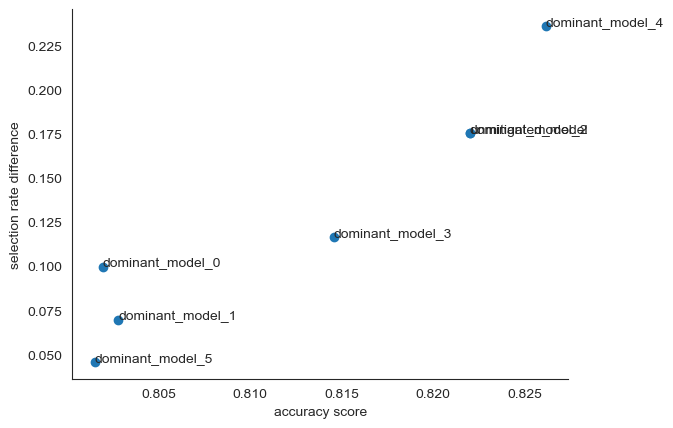

<AxesSubplot: xlabel='accuracy score', ylabel='selection rate difference'>

In [100]:
# We can evaluate the dominant models along with the unmitigated model.

# Use the unmitigated model to predict on the test data
predictions = {"unmitigated_model": unmitigated_predictor.predict(X_test)}

# Add predictions for all relevant dominant models
metric_frames = {"unmitigated_model": metric_frame}
for i in range(len(non_dominated_models)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated_models[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": performance_metric,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=A_test,
        y_true=Y_test,
        y_pred=predictions[key],
    )

# scatterplot for the models along their accuracy and selection rate
plot_model_comparison(
    x_axis_metric=performance_metric,
    y_axis_metric=fairness_metric,
    y_true=Y_test,
    y_preds=predictions,
    sensitive_features=A_test,
    point_labels=True,
    show_plot=True,
)